In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Dissertation')

Mounted at /content/drive


In [ ]:
from my_method import *
from TOPUP import *
from data_generation import *
from tensor_operation import *
import math
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

# Evaluation metrics
## Error of loading matrices estimation
We introduce the column space distance between the real loading matrices and the estimated loading matrices to measure the estimation error. Since we have different settings and under each setting we repeat our simulations 10 times, we will use box plot to show the results of three methods respectively.
## Accuracy of estimating the signal part
We firstly compute the estimated signal part, then we compute the error between the real one and the estimated one. Finally we introduce the Frobenius norm of the error to measure the estimation accuracy. Since our simulated time series is to long, in each simulation, we adopt the uniform random sampling along the time series to sample 50 "points". And we also use box plot to show the results.
## Accuracy of estimating latent dimensions.

In [ ]:
## Metric one
def metric_one(result, a_1, a_2, a_3, rep=10):
    # --------------------
    # a_1, a_2, a_3 are real loading matrics
    # --------------------
    
    A1 = np.zeros(rep*3).reshape(rep, 3)
    A2 = np.zeros(rep*3).reshape(rep, 3)
    A3 = np.zeros(rep*3).reshape(rep, 3)
    
    for i in range(rep):
        A1[i,:] = np.array([discrepancy(result[i][1][0][1],a_1),discrepancy(result[i][2][0][1],a_1),
                            discrepancy(result[i][3][1],a_1)])
        A2[i,:] = np.array([discrepancy(result[i][1][1][1],a_2),discrepancy(result[i][2][1][1],a_2),
                            discrepancy(result[i][3][2],a_2)])
        A3[i,:] = np.array([discrepancy(result[i][1][2][1],a_3),discrepancy(result[i][2][2][1],a_3),
                            discrepancy(result[i][3][3],a_3)])
    
    # Draw box plot
    TOPUP = [list(A1[:,0]),list(A2[:,0]),list(A3[:,0])]
    method_one = [list(A1[:,1]),list(A2[:,1]),list(A3[:,1])]
    method_two = [list(A1[:,2]),list(A2[:,2]),list(A3[:,2])]
    
    #箱型图名称
    labels = ["A_1", "A_2", "A_3"]
    #三个箱型图的颜色 RGB （均为0~1的数据）
    colors = [(135/255.,206/255.,235/255.), (250/255.,250/255.,210/255.), (154/255.,205/255.,50/255.)]
	  #patch_artist=True-->箱型可以更换颜色，positions=(1,1.4,1.8)-->将同一组的三个箱间隔设置为0.4，widths=0.3-->每个箱宽度为0.3 
    bplot = plt.boxplot(TOPUP, patch_artist=True,labels=labels,positions=(1,1.4,1.8),widths=0.3) 
    #将三个箱分别上色
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    bplot2 = plt.boxplot(method_one, patch_artist=True, labels=labels,positions=(2.5,2.9,3.3),widths=0.3) 
    
    for patch, color in zip(bplot2['boxes'], colors):
        patch.set_facecolor(color)

    bplot3 = plt.boxplot(method_two, patch_artist=True, labels=labels,positions=(4,4.4,4.8),widths=0.3)  
    
    for patch, color in zip(bplot3['boxes'], colors):
        patch.set_facecolor(color)

    x_position=[1,2.5,4]
    x_position_fmt=["TOPUP","Method One","Method Two"]
    plt.xticks([i + 0.8 / 2 for i in x_position], x_position_fmt)

    plt.ylabel('Column Sapce Distance')
    plt.legend(bplot['boxes'],labels,loc='upper right')  #绘制表示框，右上角绘制 
    plt.show()
    print('mean',np.mean(A1, axis=0))
    print('mean',np.mean(A2, axis=0))
    print('mean',np.mean(A3, axis=0))
    print('sd', np.std(A1, axis=0))
    print('sd', np.std(A2, axis=0))
    print('sd', np.std(A3, axis=0))

In [ ]:
## Metric Two
# Firstly write a function to compute the estimated signal part and the following error
def signal_part(data, a_1,a_2,a_3, n_sample=50, interval=20):
    # ----------------------------
    # n_sample: the number of "point" sampled from real tensor time series
    # interval = [nsimulations/n_sample]
    # data: [real tensor time series, signal part]
    # a_1, a_2, a_3; estimated loading matrices
    # ____________________________
    
    # dimension recognition
    nsimulations,d_3,d_2,d_1 = data[0].shape
    r_1 = a_1.shape[1]
    r_2 = a_2.shape[1]
    r_3 = a_3.shape[1]
    
    # uniform random sampling
    sample_index = range(1,nsimulations,interval)
    sampled_data = data[0][sample_index,:,:,:]
    sampled_signal = data[1][sample_index,:,:,:]
    
    # compute factors
    product_1 = np.zeros(r_1*d_2*d_3*n_sample).reshape(n_sample,d_3,d_2,r_1)
    for i in range(r_1):
        for j in range(d_1):
            product_1[:,:,:,i] += sampled_data[:,:,:,j] * a_1[j,i]
            
    product_2 = np.zeros(r_1*r_2*d_3*n_sample).reshape(n_sample,d_3,r_2,r_1)
    for i in range(r_2):
        for j in range(d_2):
            product_2[:,:,i,:] += product_1[:,:,j,:] * a_2[j,i]
    
    factor = np.zeros(r_1*r_2*r_3*n_sample).reshape(n_sample,r_3,r_2,r_1)        
    for i in range(r_3):
        for j in range(d_3):
            factor[:,i,:,:] += product_2[:,j,:,:] * a_3[j,i]
            
    # compute estimated signal part
    signal_1 = np.zeros(d_1*r_2*r_3*n_sample).reshape(n_sample,r_3,r_2,d_1)
    for i in range(d_1):
        for j in range(r_1):
            signal_1[:,:,:,i] += factor[:,:,:,j] * a_1[i,j]
    
    signal_2 = np.zeros(d_1*d_2*r_3*n_sample).reshape(n_sample,r_3,d_2,d_1)
    for i in range(d_2):
        for j in range(r_2):
            signal_2[:,:,i,:] += signal_1[:,:,j,:] * a_2[i,j]
    
    signal = np.zeros(d_1*d_2*d_3*n_sample).reshape(n_sample,d_3,d_2,d_1)
    for i in range(d_3):
        for j in range(r_3):
            signal[:,i,:,:] += signal_2[:,j,:,:] * a_3[i,j]
    
    error = sampled_signal - signal
    
    return error

# Then write a function to compute Frobenius norm of the error
def Frobenius(error, n_sample=50):
    f_norm = np.ones(n_sample)
    f_norm_square = error * error
    for i in range(n_sample):
        f_norm[i] = np.sqrt(np.sum(f_norm_square[i,:,:,:]))
        
    return f_norm

In [ ]:
# Integrated into one function
def metric_two(result, n_samples=50, intervals=20, rep=10):
    
    f = np.zeros(rep*n_samples*3).reshape(rep, n_samples, 3)    
    for i in range(rep):
        f[i,:,0] = Frobenius(signal_part(result[i][0], result[i][1][0][1],result[i][1][1][1],result[i][1][2][1], 
                                         n_sample=n_samples, interval=intervals), n_sample=n_samples)
        f[i,:,1] = Frobenius(signal_part(result[i][0], result[i][2][0][1],result[i][2][1][1],result[i][2][2][1], 
                                         n_sample=n_samples, interval=intervals), n_sample=n_samples)
        f[i,:,2] = Frobenius(signal_part(result[i][0], result[i][3][1],result[i][3][2],result[i][3][3], 
                                         n_sample=n_samples, interval=intervals), n_sample=n_samples)
    
    F = f.reshape(rep*n_samples, 3)
    # Draw box plot
    F_norm = {
        'TOPUP': list(F[:,0]),
        'Method One': list(F[:,1]),
        'Method Two': list(F[:,2])
    }
    print(np.mean(F, axis=0))
    print(np.std(F, axis=0))
    df = pd.DataFrame(F_norm)
    df.plot.box(title="Accuracy of estimating the signal part - Frobenius norm", showmeans=True)
    plt.show()

In [ ]:
## Metric Three
def metric_three(result, rep=10):
  A1 = np.zeros(rep*2).reshape(rep, 2)
  A2 = np.zeros(rep*2).reshape(rep, 2)
  A3 = np.zeros(rep*2).reshape(rep, 2)
  for i in range(rep):
    A1[i,:] = np.array([result[i][1][0][0],result[i][2][0][0]])
    A2[i,:] = np.array([result[i][1][1][0],result[i][2][1][0]])
    A3[i,:] = np.array([result[i][1][2][0],result[i][2][2][0]])
  print(A1.T)
  print(A2.T)
  print(A3.T)

# Setting I
In order to explore the impact of different signal strength of tensor time series on the estimation, including the impact on the convergence rate and the estimation accuracy. Set phi = 0.2, 0.6 respectively, set nsimulations = 100,300, 600, 1000 respectively. Under such situation, factor time series is correlated temporally while noise term is white.
For data, set d_1=d_2=d_3=10, r_1=3, r_2=r_3=2.

In [ ]:
def test_1(phi,a_1,a_2,a_3,d_1=10,d_2=10,d_3=10,nsim=1000,rep=10):
    results = []
    
    for i in range(rep):
        data = setting_1(d_1,d_2,d_3,phi,a_1,a_2,a_3, nsimulations=nsim)
        centered_tensor = centralization(data[0],nsimulations=nsim)
        method_1 = TOPUP_Method(centered_tensor)
        method_2 = matrix_estimator(centered_tensor)
        # method 3
        tensor_covariance = tensor_cov(centered_tensor)
        # r_1,r_2,r_3
        r1 = method_2[0][0]
        r2 = method_2[1][0]
        r3 = method_2[2][0]
        method_3 = HOOI(tensor_covariance,d_1,d_2,d_3,r1,r2,r3)
        
        results.append([data, method_1, method_2, method_3])
    
    return results

In [ ]:
# loading matrix
a1 = np.random.uniform(low=-2.0, high=3.5, size=(10,3))
a2 = np.random.uniform(low=-2.0, high=3.5, size=(10,2))
a3 = np.random.uniform(low=-2.0, high=3.5, size=(10,2))

In [ ]:
# phi=0.2, nsimulations=100
re_1 = test_1(0.2,a1,a2,a3,nsim=100, rep=10)

/content/drive/My Drive/Dissertation/my_method.py:116: RuntimeWarning: invalid value encountered in double_scalars
  lamb = eigen_vals[0]**0.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
/content/drive/My Drive/Dissertation/my_method.py:116: RuntimeWarning: invalid value encountered in double_scalars
  lamb = eigen_vals[0]**0.5


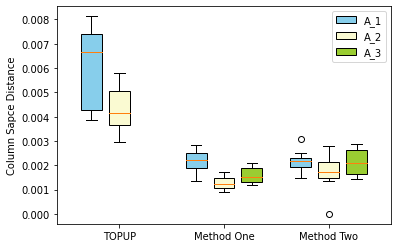

mean [0.00608109 0.00216722 0.00215659]
mean [0.00430677 0.00126919 0.0017113 ]
mean [       nan 0.00159245 0.00212429]
sd [0.00160723 0.00044197 0.00043163]
sd [0.00090482 0.00025903 0.00071456]
sd [       nan 0.00030782 0.00052318]


In [ ]:
metric_one(re_1, a1, a2, a3)

[5.49198805 4.65712366 4.7283147 ]


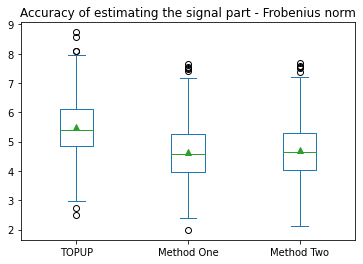

In [ ]:
metric_two(re_1, n_samples=20, intervals=5, rep=10)

In [ ]:
metric_three(re_1)

[[3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]]
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]]
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]]


In [ ]:
# phi=0.2, nsimulations=300 
re_2 = test_1(0.2,a1,a2,a3,nsim=300, rep=10)

/content/drive/My Drive/Dissertation/my_method.py:116: RuntimeWarning: invalid value encountered in double_scalars
  lamb = eigen_vals[0]**0.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


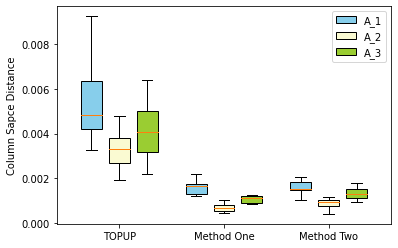

mean [0.005407   0.00159623 0.00160853]
mean [0.00327887 0.00069835 0.00085798]
mean [0.0041049  0.00107031 0.00133802]
sd [0.00177474 0.00028839 0.00029766]
sd [0.00086561 0.00017512 0.00022231]
sd [0.00121616 0.0001686  0.00027585]


In [ ]:
metric_one(re_2, a1, a2, a3)

[5.32557507 4.5656582  4.54838392]


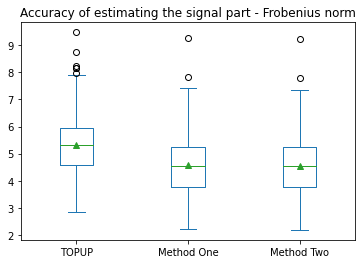

In [ ]:
metric_two(re_2, n_samples=30, intervals=10, rep=10)

In [ ]:
metric_three(re_2)

[[3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]]
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]]
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]]


In [ ]:
# phi=0.2, nsimulations=600 
re_3 = test_1(0.2,a1,a2,a3,nsim=600, rep=10)

/content/drive/My Drive/Dissertation/my_method.py:116: RuntimeWarning: invalid value encountered in double_scalars
  lamb = eigen_vals[0]**0.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


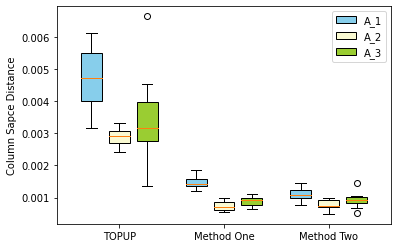

mean [0.00469005 0.00147956 0.00109765]
mean [0.00288403 0.00073704 0.00078095]
mean [0.00340532 0.00089322 0.00092807]
sd [0.00100025 0.00018427 0.00018985]
sd [0.00027067 0.00015303 0.00014458]
sd [0.00138961 0.00013757 0.00023256]


In [ ]:
metric_one(re_3, a1, a2, a3)

[5.17352693 4.60807026 4.56853144]


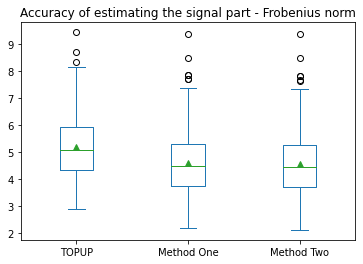

In [ ]:
metric_two(re_3, n_samples=40, intervals=15, rep=10)

In [ ]:
metric_three(re_3)

[[3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]]
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]]
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]]


In [ ]:
# phi=0.2, nsimulations=1000 
re_4 = test_1(0.2,a1,a2,a3,nsim=1000, rep=10)

/content/drive/My Drive/Dissertation/my_method.py:116: RuntimeWarning: invalid value encountered in double_scalars
  lamb = eigen_vals[0]**0.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


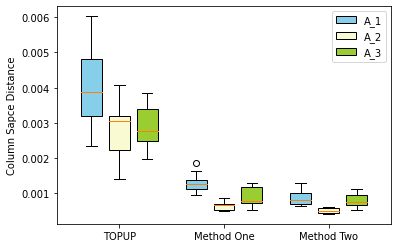

mean [0.00396932 0.00130094 0.00087857]
mean [0.00274982 0.00065042 0.000514  ]
mean [0.00290661 0.00091949 0.00081219]
sd [0.00117506 0.00026337 0.00021411]
sd [7.74598538e-04 1.11039729e-04 7.06863680e-05]
sd [0.00058754 0.00026699 0.00019998]


In [ ]:
metric_one(re_4, a1, a2, a3)

[4.8188612  4.46554547 4.40686134]


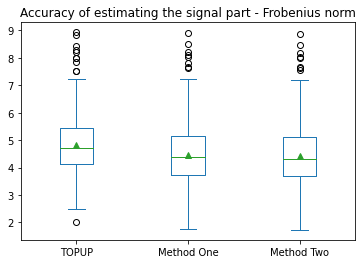

In [ ]:
metric_two(re_4, n_samples=50, intervals=20, rep=10)

In [ ]:
metric_three(re_4)

[[3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]]
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]]
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]]


In [ ]:
# phi=0.6, nsimulations=100 
re_5 = test_1(0.6,a1,a2,a3,nsim=100, rep=10)

/content/drive/My Drive/Dissertation/my_method.py:116: RuntimeWarning: invalid value encountered in double_scalars
  lamb = eigen_vals[0]**0.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


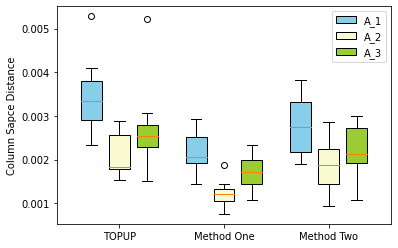

mean [0.00344034 0.0021602  0.00276186]
mean [0.00209391 0.00122941 0.0018388 ]
mean [0.0026867  0.00171327 0.00223831]
sd [0.00082353 0.00047018 0.00063543]
sd [0.00046494 0.00028958 0.00058794]
sd [0.00094813 0.000361   0.00058693]


In [ ]:
metric_one(re_5, a1, a2, a3)

[4.93872088 4.74487197 4.83953567]


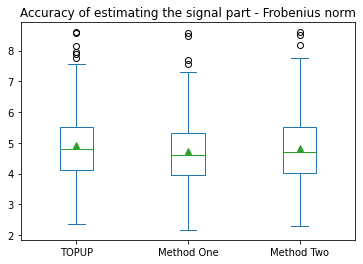

In [ ]:
metric_two(re_5, n_samples=20, intervals=5, rep=10)

In [ ]:
# phi=0.6, nsimulations=300 
re_6 = test_1(0.6,a1,a2,a3,nsim=300, rep=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


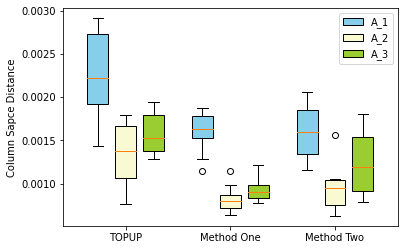

mean [0.00227544 0.00160743 0.00161109]
mean [0.00133581 0.00082228 0.00094437]
mean [0.00159089 0.00093269 0.00124222]
sd [0.00048561 0.00022913 0.00030698]
sd [0.00036135 0.00014495 0.0002552 ]
sd [0.0002439  0.00012975 0.00035419]


In [ ]:
metric_one(re_6, a1, a2, a3)

[4.80892085 4.73309765 4.71987395]


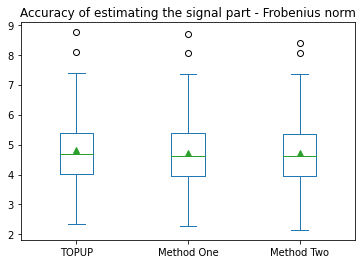

In [ ]:
metric_two(re_6, n_samples=30, intervals=10, rep=10)

In [ ]:
# phi=0.6, nsimulations=600 
re_7 = test_1(0.6,a1,a2,a3,nsim=600, rep=10)

/content/drive/My Drive/Dissertation/my_method.py:116: RuntimeWarning: invalid value encountered in double_scalars
  lamb = eigen_vals[0]**0.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


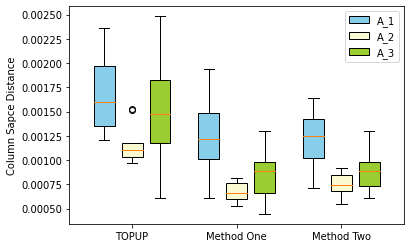

mean [0.00169659 0.00125253 0.00119301]
mean [0.00116434 0.00067555 0.0007516 ]
mean [0.00155235 0.00084877 0.00089728]
sd [0.00039004 0.00038806 0.00029657]
sd [1.89637617e-04 9.76206528e-05 1.14185247e-04]
sd [0.00055036 0.00025931 0.00020864]


In [ ]:
metric_one(re_7, a1, a2, a3)

[4.60786854 4.58676987 4.54352143]


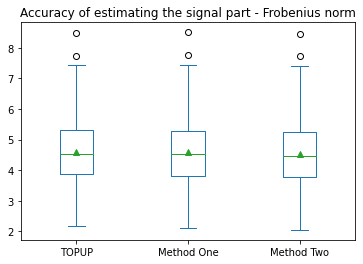

In [ ]:
metric_two(re_7, n_samples=40, intervals=15, rep=10)

In [ ]:
# phi=0.6, nsimulations=1000 
re_8 = test_1(0.6,a1,a2,a3,nsim=1000, rep=10)

/content/drive/My Drive/Dissertation/my_method.py:116: RuntimeWarning: invalid value encountered in double_scalars
  lamb = eigen_vals[0]**0.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


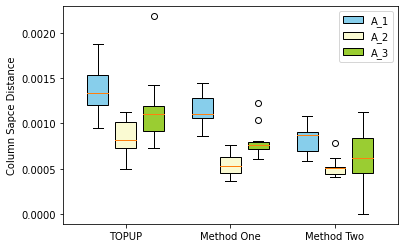

mean [0.00137425 0.00114639 0.0008313 ]
mean [0.00084629 0.00054816 0.00051694]
mean [0.00116323 0.00080776 0.00062998]
sd [0.00026893 0.00017741 0.00016413]
sd [0.00019086 0.00013037 0.0001087 ]
sd [0.00039212 0.00017694 0.00031088]


In [ ]:
metric_one(re_8, a1, a2, a3)

[4.57523359 4.58960079 4.53477014]


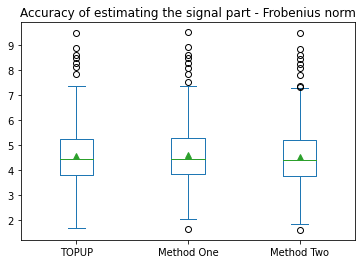

In [ ]:
metric_two(re_8, n_samples=50, intervals=20, rep=10)

## Setting II
In order to explore the impact of different temporal dependence within noise term on the estimation. Set signal part to be weakly correlated temporally with phi=0.6. Set noise term to be weakly correlated with correlation parameter(also refer to phi here) = 0.2, 0.6 respectively. Set nsimulations = 100, 300, 600, 1000 respectively.Under such situation,both factor time series and noise term are correlated temporally.

In [ ]:
def test_2(phi,a_1,a_2,a_3,d_1=10,d_2=10,d_3=10,nsim=1000,rep=10):
    # ------------------------
    # Note that phi here represents correlation parameter of noise process.
    # ------------------------
    results = []
    
    for i in range(rep):
        data = setting_2(d_1,d_2,d_3,phi,a_1,a_2,a_3,nsimulations=nsim)
        centered_tensor = centralization(data[0],nsimulations=nsim)
        method_1 = TOPUP_Method(centered_tensor)
        method_2 = matrix_estimator(centered_tensor)
        # method 3
        tensor_covariance = tensor_cov(centered_tensor)
        # r_1,r_2,r_3
        r1 = method_2[0][0]
        r2 = method_2[1][0]
        r3 = method_2[2][0]
        method_3 = HOOI(tensor_covariance,d_1,d_2,d_3,r1,r2,r3)
        
        results.append([data, method_1, method_2, method_3])
    
    return results

In [ ]:
# phi=0.2, nsimulations=100 
re_9 = test_2(0.2,a1,a2,a3,nsim=100, rep=10)

/content/drive/My Drive/Dissertation/my_method.py:116: RuntimeWarning: invalid value encountered in double_scalars
  lamb = eigen_vals[0]**0.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


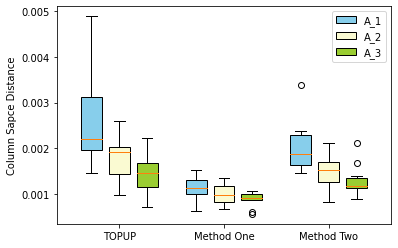

mean [0.00255893 0.00114301 0.00203931]
mean [0.00179373 0.00099103 0.00148295]
mean [0.00147713 0.00088013 0.0013043 ]
sd [0.00099243 0.00025807 0.00055438]
sd [0.00044846 0.00021683 0.00039192]
sd [0.00047066 0.00016312 0.00033501]


In [ ]:
metric_one(re_9, a1, a2, a3)

[3.64737965 3.43813323 3.51120283]


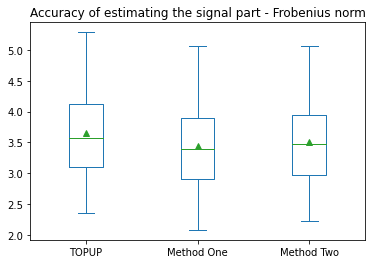

In [ ]:
metric_two(re_9, n_samples=20, intervals=5, rep=10)

In [ ]:
metric_three(re_9)

[[3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]]
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]]
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]]


In [ ]:
# phi=0.2, nsimulations=300 
re_10 = test_2(0.2,a1,a2,a3,nsim=300, rep=10)

/content/drive/My Drive/Dissertation/my_method.py:116: RuntimeWarning: invalid value encountered in double_scalars
  lamb = eigen_vals[0]**0.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


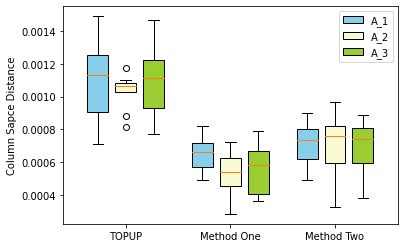

mean [0.00109665 0.00065239 0.00071305]
mean [0.00103191 0.00052764 0.00071219]
mean [0.00109641 0.00055596 0.00070417]
sd [2.23073790e-04 9.66997437e-05 1.37559408e-04]
sd [0.00010101 0.00013163 0.00018833]
sd [0.00021578 0.00014212 0.00015433]


In [ ]:
metric_one(re_10, a1, a2, a3)

[3.48550482 3.40794115 3.42380303]


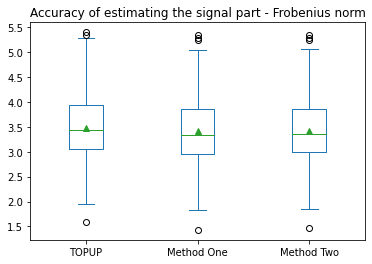

In [ ]:
metric_two(re_10, n_samples=30, intervals=10, rep=10)

In [ ]:
# phi=0.2, nsimulations=600 
re_11 = test_2(0.2,a1,a2,a3,nsim=600, rep=10)

/content/drive/My Drive/Dissertation/my_method.py:116: RuntimeWarning: invalid value encountered in double_scalars
  lamb = eigen_vals[0]**0.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


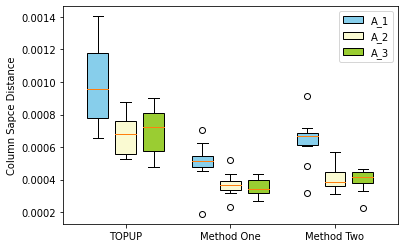

mean [0.00099933 0.00050411 0.00063705]
mean [0.0006826  0.00036955 0.00041673]
mean [0.00070005 0.00034914 0.00039553]
sd [0.00024633 0.00012692 0.00014665]
sd [1.24570783e-04 7.17056391e-05 7.81730234e-05]
sd [1.40750791e-04 5.47405220e-05 6.90357497e-05]


In [ ]:
metric_one(re_11, a1, a2, a3)

[3.48187914 3.43018623 3.43658802]


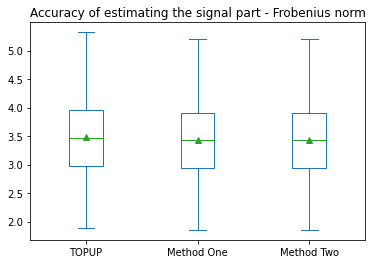

In [ ]:
metric_two(re_11, n_samples=40, intervals=15, rep=10)

In [ ]:
# phi=0.2, nsimulations=1000 
re_12 = test_2(0.2,a1,a2,a3,nsim=1000, rep=10)

/content/drive/My Drive/Dissertation/my_method.py:116: RuntimeWarning: invalid value encountered in double_scalars
  lamb = eigen_vals[0]**0.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


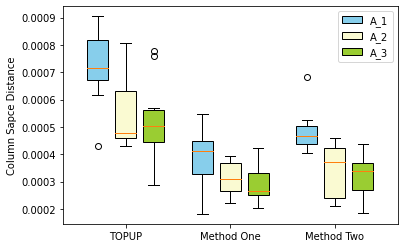

mean [0.00071747 0.00039842 0.0004855 ]
mean [0.00055005 0.00031355 0.00034183]
mean [0.00051847 0.00029101 0.00032152]
sd [1.28644416e-04 1.07127764e-04 7.54414823e-05]
sd [1.21456510e-04 5.63151079e-05 9.41384914e-05]
sd [1.48347384e-04 6.58029585e-05 7.23717275e-05]


In [ ]:
metric_one(re_12, a1, a2, a3)

[3.45129074 3.42204075 3.42538079]


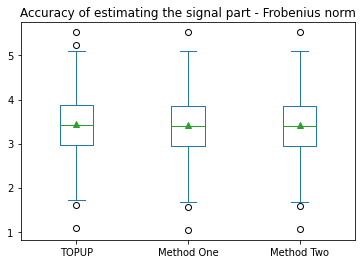

In [ ]:
metric_two(re_12, n_samples=50, intervals=20, rep=10)

In [ ]:
# phi=0.6, nsimulations=100 
re_13 = test_2(0.8,a1,a2,a3,nsim=100, rep=10)

/content/drive/My Drive/Dissertation/my_method.py:116: RuntimeWarning: invalid value encountered in double_scalars
  lamb = eigen_vals[0]**0.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


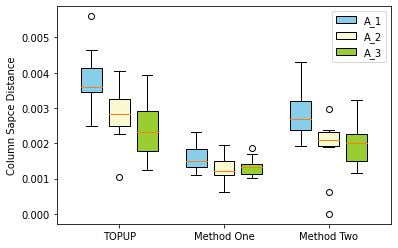

mean [0.00374361 0.00161099 0.00281691]
mean [0.00285842 0.00126947 0.00187186]
mean [0.00247172 0.00134255 0.00204625]
sd [0.00088589 0.00038465 0.00064966]
sd [0.00083806 0.00035949 0.00083897]
sd [0.00085069 0.00025749 0.00068465]


In [ ]:
metric_one(re_13, a1, a2, a3)

[3.89063613 3.50362409 3.63674557]


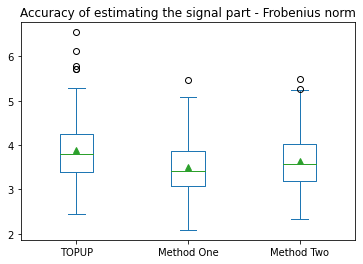

In [ ]:
metric_two(re_13, n_samples=20, intervals=5, rep=10)

In [ ]:
metric_three(re_13)

[[3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]]
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]]
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]]


In [ ]:
# phi=0.6, nsimulations=300 
re_14 = test_2(0.8,a1,a2,a3,nsim=300, rep=10)

/content/drive/My Drive/Dissertation/my_method.py:116: RuntimeWarning: invalid value encountered in double_scalars
  lamb = eigen_vals[0]**0.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


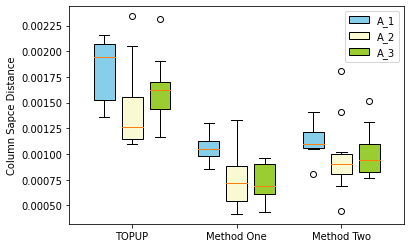

mean [0.00181409 0.00106543 0.0011265 ]
mean [0.00144428 0.00073646 0.00097464]
mean [0.00163276 0.00071961 0.00100925]
sd [0.00029633 0.00012334 0.00015423]
sd [0.00040894 0.00026005 0.00036287]
sd [0.00029563 0.0001773  0.00023135]


In [ ]:
metric_one(re_14, a1, a2, a3)

[3.5735587  3.38547549 3.41045983]


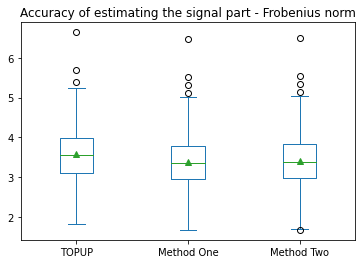

In [ ]:
metric_two(re_14, n_samples=30, intervals=10, rep=10)

In [ ]:
metric_three(re_14)

[[3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]]
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]]
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]]


In [ ]:
# phi=0.6, nsimulations=600 
re_15 = test_2(0.8,a1,a2,a3,nsim=600, rep=10)

/content/drive/My Drive/Dissertation/my_method.py:116: RuntimeWarning: invalid value encountered in double_scalars
  lamb = eigen_vals[0]**0.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


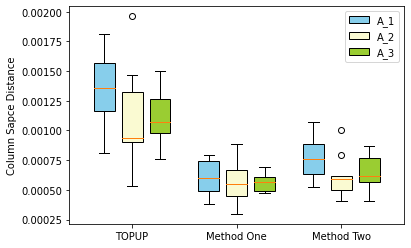

mean [0.00132389 0.00060617 0.00076648]
mean [0.00108261 0.00056368 0.00061203]
mean [0.00109817 0.00055923 0.00064181]
sd [0.00031431 0.00013954 0.00016281]
sd [0.0003951  0.00017668 0.00016238]
sd [2.26531480e-04 7.35943068e-05 1.48505067e-04]


In [ ]:
metric_one(re_15, a1, a2, a3)

[3.53045179 3.42607901 3.43868706]


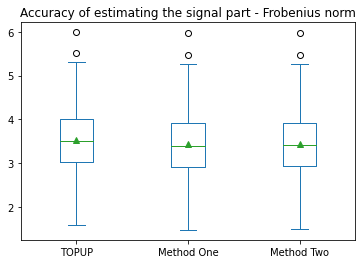

In [ ]:
metric_two(re_15, n_samples=40, intervals=15, rep=10)

In [ ]:
# phi=0.6, nsimulations=1000
re_16 = test_2(0.8,a1,a2,a3,nsim=1000, rep=10)

/content/drive/My Drive/Dissertation/my_method.py:116: RuntimeWarning: invalid value encountered in double_scalars
  lamb = eigen_vals[0]**0.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


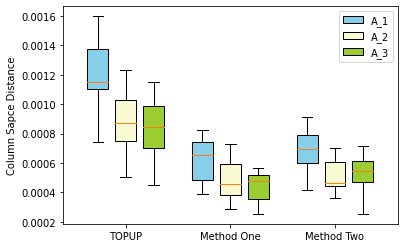

mean [0.00118709 0.00062476 0.00068247]
mean [0.00087161 0.00048383 0.00051823]
mean [0.0008469  0.00043998 0.00053197]
sd [0.00028177 0.00014757 0.00015701]
sd [0.00023428 0.00013614 0.00011046]
sd [2.12098491e-04 9.83957401e-05 1.32919063e-04]


In [ ]:
metric_one(re_16, a1, a2, a3)

[3.49544216 3.42451249 3.43237385]


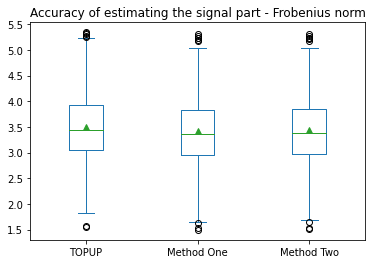

In [ ]:
metric_two(re_16, n_samples=50, intervals=20, rep=10)